In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)



Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

DATA_ROOT = Path("dataset_dividido_v1")
train_dir = DATA_ROOT / "train"
val_dir   = DATA_ROOT / "val"
test_dir  = DATA_ROOT / "test"

for p in (train_dir, val_dir, test_dir):
    if not p.exists():
        print(f"Warning: carpeta no encontrada: {p}")

train_set = datasets.ImageFolder(train_dir, transform=transform)
val_set   = datasets.ImageFolder(val_dir, transform=transform)
test_set  = datasets.ImageFolder(test_dir, transform=transform)

#DataLoaders
batch_size = 16
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

num_classes = len(train_set.classes)
print("Clases:", train_set.classes)
print(f"Tamaños -> train: {len(train_set)}, val: {len(val_set)}, test: {len(test_set)}")

class_to_idx = train_set.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
print("class_to_idx:", class_to_idx)


Clases: ['Botellas de Cloro', 'Cajas de condones', 'Condones', 'Esponjas', 'Placas madre']
Tamaños -> train: 5015, val: 319, test: 938
class_to_idx: {'Botellas de Cloro': 0, 'Cajas de condones': 1, 'Condones': 2, 'Esponjas': 3, 'Placas madre': 4}


In [8]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.scale = d_k ** 0.5

    def forward(self, Q, K, V):
        attn_scores = (Q @ K.transpose(-2, -1)) / self.scale
        attn_weights = torch.softmax(attn_scores, dim=-1)
        return attn_weights @ V


In [9]:
class AttentionClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.proj = nn.Linear(64, 64)
        self.attention = ScaledDotProductAttention(d_k=64)
        
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        feat = self.cnn(x)                          
        B, C, H, W = feat.shape

        tokens = feat.reshape(B, C, H*W).permute(0, 2, 1)  # (B, 1024, 64)

        Q = self.proj(tokens)
        K = self.proj(tokens)
        V = self.proj(tokens)

        attn_output = self.attention(Q, K, V)

        global_feat = attn_output.mean(dim=1)

        return self.fc(global_feat)


In [10]:
model = AttentionClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [11]:
def evaluate(model, loader):
    model.eval()
    correct, total, running_loss = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            preds = model(imgs)
            loss = criterion(preds, labels)

            running_loss += loss.item()

            _, predicted = torch.max(preds, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total


In [12]:
epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)

        preds = model(imgs)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(preds, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dl)
    train_acc  = correct / total

    val_loss, val_acc = evaluate(model, val_dl)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")


Epoch 1/30 | Train Loss: 1.4574 - Train Acc: 0.3571 | Val Loss: 1.3149 - Val Acc: 0.4765
Epoch 2/30 | Train Loss: 1.2305 - Train Acc: 0.5071 | Val Loss: 1.2012 - Val Acc: 0.4796
Epoch 2/30 | Train Loss: 1.2305 - Train Acc: 0.5071 | Val Loss: 1.2012 - Val Acc: 0.4796
Epoch 3/30 | Train Loss: 1.1704 - Train Acc: 0.5332 | Val Loss: 1.1403 - Val Acc: 0.5361
Epoch 3/30 | Train Loss: 1.1704 - Train Acc: 0.5332 | Val Loss: 1.1403 - Val Acc: 0.5361
Epoch 4/30 | Train Loss: 1.1414 - Train Acc: 0.5585 | Val Loss: 1.1391 - Val Acc: 0.5674
Epoch 4/30 | Train Loss: 1.1414 - Train Acc: 0.5585 | Val Loss: 1.1391 - Val Acc: 0.5674
Epoch 5/30 | Train Loss: 1.0976 - Train Acc: 0.5763 | Val Loss: 1.1063 - Val Acc: 0.5549
Epoch 5/30 | Train Loss: 1.0976 - Train Acc: 0.5763 | Val Loss: 1.1063 - Val Acc: 0.5549
Epoch 6/30 | Train Loss: 1.0793 - Train Acc: 0.5850 | Val Loss: 1.0764 - Val Acc: 0.5925
Epoch 6/30 | Train Loss: 1.0793 - Train Acc: 0.5850 | Val Loss: 1.0764 - Val Acc: 0.5925
Epoch 7/30 | Train Lo

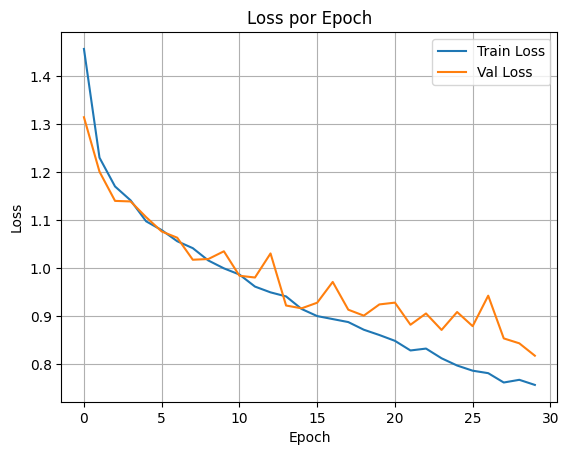

In [13]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss por Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


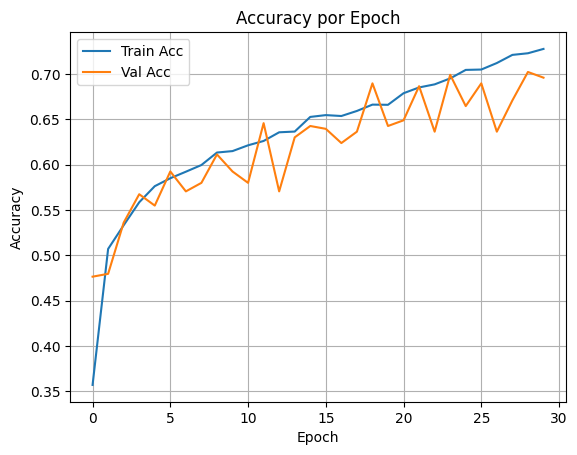

In [14]:
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy por Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


In [15]:
test_loss, test_acc = evaluate(model, test_dl)

print("\n==== RESULTADO FINAL ====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")



==== RESULTADO FINAL ====
Test Loss: 0.8355
Test Accuracy: 0.6898
